# 5 - Técnicas de interpretabilidad de modelos.

En este notebook se explora la interpretabilidad del modelo. La explicabilidad en *deep learning* es clave para validar modelos clínicos y entender sus decisiones. Existen distintos enfoques de *explainable artificial intelligence* (XAI), como *saliency maps*, *Grad-CAM*, *LRP*, *SHAP* o *Integrated Gradients* (IG). Estas técnicas pueden clasificarse según su mecanismo (basadas en gradientes, perturbaciones o descomposición), su aplicación (post-hoc o integradas en el modelo) y su objetivo (funcional, arquetípico o relevancia local).

Hasta donde sabemos, no hay técnicas XAI específicamente diseñadas para modelos que utilizan datos de resonancia magnética funcional, y las pocas existentes adaptan métodos creados para imágenes estáticas. Por ejemplo, el modelo DeepLight integra interpretabilidad en la arquitectura, pero requiere redes específicas. En nuestro caso, preferimos una técnica post-hoc, sin modificar el modelo (*Integrated Gradients*). Este método, basado en gradientes y soportado oficialmente en TensorFlow, permite estimar la relevancia de cada voxel para una predicción concreta y es compatible con nuestro enfoque secuencial CNN+GRU.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import imageio
from scipy.stats import ttest_ind
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, regularizers
from keras.saving import register_keras_serializable

In [3]:
input_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)"
output_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/data/visualizations"
X = np.load(os.path.join(input_dir, "data/splits/X_val_tl.npy"))
y = np.load(os.path.join(input_dir, "data/splits/y_val_tl.npy"))

## 5.1 - Carga y preparación del modelo.
Se define la arquitectura CNN+GRU basada en MobileNetV2 y se cargan los pesos entrenados. El modelo se utilizará para aplicar interpretabilidad con IG.


In [4]:
@register_keras_serializable()
class MOBILENETV2_GRU(tf.keras.Model):
    """
    Modelo híbrido basado en MobileNetV2 y GRU para la clasificación binaria de secuencias fMRI 2D.

    Esta arquitectura utiliza MobileNetV2 preentrenado sobre ImageNet como extractor de características espaciales,
    aplicándolo a cada paso temporal mediante `TimeDistributed`. Posteriormente, una capa GRU modela la dinámica
    temporal de la secuencia. El modelo incluye además una capa densa y una capa dropout para mejorar la
    generalización.

    MobileNetV2 ha sido seleccionado por su bajo número de parámetros en comparación con otras arquitecturas
    como VGG o ResNet, lo cual resulta útil en entornos con restricciones computacionales y conjuntos de datos reducidos.

    Parameters
    ----------
    input_shape : tuple, optional
        Forma esperada del tensor de entrada sin incluir el batch. Por defecto (95, 224, 224, 3), donde:
            - 95 representa el número de pasos temporales,
            - 224x224 el tamaño de las imágenes redimensionadas,
            - 3 canales RGB necesarios para compatibilidad con MobileNetV2.
    num_classes : int, optional
        Número de clases. Por defecto 1 (clasificación binaria con activación sigmoide).
    gru_units : int, optional
        Número de unidades de la capa GRU. Por defecto 64.
    dropout_rate : float, optional
        Tasa de dropout aplicada después de la capa densa. Por defecto 0.5.

    Returns
    -------
    tf.Tensor
        Tensor con la probabilidad predicha por clase. En clasificación binaria, la forma es (batch_size, 1).
    """
    def __init__(self, input_shape=(95, 224, 224, 3), num_classes=1, gru_units=64, dropout_rate=0.5):
        super(MOBILENETV2_GRU, self).__init__()
        l2 = regularizers.l2(1e-4)

        base_cnn = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_cnn.trainable = False

        self.feature_extractor = tf.keras.Sequential([
            base_cnn,
            layers.GlobalAveragePooling2D()
        ])

        self.td_extractor = layers.TimeDistributed(self.feature_extractor)

        self.gru = layers.GRU(gru_units, return_sequences=False)

        self.dense = layers.Dense(64, activation='relu', kernel_regularizer=l2)
        self.dropout = layers.Dropout(dropout_rate)
        self.out = layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')

    def call(self, inputs, training=False):
        x = self.td_extractor(inputs)
        x = self.gru(x)
        x = self.dense(x)
        if training:
            x = self.dropout(x, training=training)
        return self.out(x)

In [5]:
model = MOBILENETV2_GRU(input_shape=(95, 224, 224, 3), num_classes=1)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
dummy_input = tf.zeros((1, 95, 224, 224, 3))
_ = model(dummy_input, training=False)
model.load_weights(os.path.join(input_dir, "models/MOBILENETV2_GRU.weights.h5"))

## 5.2 - Cálculo de atribuciones mediante Integrated Gradients.

En esta sección se definen las funciones necesarias para aplicar la técnica de interpretabilidad Integrated Gradients (IG) al modelo CNN+GRU. Posteriormente, se calcula la importancia de cada voxel/píxel en cada muestra, tanto a nivel temporal como espacial. Los resultados se almacenan para su posterior análisis
sin necesidad de volver a ejecutar el modelo.

Las funciones se han adaptado de la metodología original de TensorFlow para trabajar con los datos de RMf. La metodología original se puede encontrar en el siguiente enlace: https://www.tensorflow.org/tutorials/interpretability/integrated_gradients?hl=es-419.

In [7]:
def interpolate_inputs(baseline, input, alphas):
    """
    Interpola linealmente entre la entrada de referencia (baseline) y la entrada real.

    Esta función genera una secuencia de entradas intermedias que se utilizarán para
    aproximar la integral en el método Integrated Gradients.

    Parameters
    ----------
    baseline : tf.Tensor
        Tensor de referencia, normalmente un tensor de ceros con la misma forma que la entrada.
    input : tf.Tensor
        Entrada real que se quiere explicar.
    alphas : tf.Tensor
        Tensor 1D de coeficientes entre 0 y 1 que definen los pasos de interpolación.

    Returns
    -------
    tf.Tensor
        Tensor con las entradas interpoladas. Su forma es (m_steps+1, ..., input_shape).
    """
    alphas = tf.reshape(alphas, [-1, 1, 1, 1, 1, 1])
    baseline_exp = tf.expand_dims(baseline, axis=0)
    input_exp = tf.expand_dims(input, axis=0)
    delta = input_exp - baseline_exp
    interpolated = baseline_exp + alphas * delta
    return tf.squeeze(interpolated, axis=1)

@tf.function
def compute_gradients(model, inputs, target_class_idx):
    """
    Calcula los gradientes de la predicción del modelo respecto a la entrada.

    Utiliza `tf.GradientTape` para obtener los gradientes de la clase objetivo
    con respecto a las entradas, necesarios para el cálculo de Integrated Gradients.

    Parameters
    ----------
    model : tf.keras.Model
        Modelo entrenado que se quiere interpretar.
    inputs : tf.Tensor
        Entrada (o batch) sobre la que calcular los gradientes.
    target_class_idx : int
        Índice de la clase objetivo para la que se desea la explicación.

    Returns
    -------
    tf.Tensor
        Tensor con los gradientes de la salida respecto a la entrada, de la misma forma que `inputs`.
    """
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        preds = model(inputs, training=False)
        if preds.shape[-1] == 1:
            probs = tf.squeeze(preds, axis=-1)
        else:
            probs = preds[:, target_class_idx]
    grads = tape.gradient(probs, inputs)
    return grads

def integrated_gradients(model, input, baseline=None, target_class_idx=0, m_steps=50):
    """
    Calcula las atribuciones mediante el método Integrated Gradients.

    Estima la relevancia de cada voxel/píxel acumulando los gradientes
    entre una entrada de referencia (baseline) y la entrada real, a lo largo
    de una trayectoria lineal definida por `m_steps`.

    Parameters
    ----------
    model : tf.keras.Model
        Modelo entrenado a interpretar.
    input : tf.Tensor
        Entrada a explicar (por ejemplo, una secuencia fMRI de forma (1, T, H, W, C)).
    baseline : tf.Tensor, optional
        Entrada de referencia para comparación. Si no se indica, se usa un tensor de ceros.
    target_class_idx : int, optional
        Índice de la clase para la cual se genera la explicación. Por defecto 0.
    m_steps : int, optional
        Número de pasos de interpolación para aproximar la integral. Por defecto 50.

    Returns
    -------
    np.ndarray
        Atribuciones de entrada obtenidas con Integrated Gradients. Tiene la misma forma que `input`.
    """
    if baseline is None:
        baseline = tf.zeros_like(input)

    alphas = tf.linspace(0.0, 1.0, m_steps + 1)
    interpolated_inputs = interpolate_inputs(baseline, input, alphas)

    grads = []
    for i in range(m_steps + 1):
        grad = compute_gradients(model, interpolated_inputs[i:i+1], target_class_idx)
        grads.append(grad)

    avg_grads = tf.reduce_mean(tf.stack(grads), axis=0)
    integrated_grads = (input - baseline) * avg_grads
    return integrated_grads.numpy()

In [8]:
"""
Calcula y almacena las atribuciones generadas por Integrated Gradients para cada muestra.

Para cada sujeto en el conjunto de datos, se calcula:
- La curva de atribución temporal media por frame (attributions_temporal),
- Las atribuciones espaciales completas por frame (attributions_spatial).

Estas variables permiten posteriormente analizar diferencias entre clases tanto en la dimensión
temporal como espacial sin necesidad de volver a ejecutar el modelo.

Variables
---------
attributions_temporal : np.ndarray, shape (n_samples, n_frames)
    Importancia media por frame para cada sujeto.

attributions_spatial : np.ndarray, shape (n_samples, n_frames, height, width, channels)
    Atribuciones completas por voxel/píxel para cada frame de cada sujeto.
"""
attributions_temporal = []
attributions_spatial = []

for i in tqdm(range(len(X))):
    x = X[i:i+1]
    baseline = tf.zeros_like(x)

    attributions = integrated_gradients(
        model, x,
        baseline=baseline,
        target_class_idx=0,
        m_steps=50
    )

    attributions_spatial.append(attributions[0])

    temporal_curve = np.mean(np.abs(attributions[0]), axis=(1, 2, 3))
    attributions_temporal.append(temporal_curve)

attributions_temporal = np.array(attributions_temporal)
attributions_spatial = np.array(attributions_spatial)

100%|██████████| 31/31 [18:56<00:00, 36.67s/it]


# 5.3 - Análisis temporal por clase.
En esta sección se analizan las atribuciones temporales generadas por *Integrated Gradients*, agrupando las curvas de importancia media por frame según la clase (control vs. depresión).

Se calcula la curva de atribución media para cada grupo y se visualiza la diferencia entre ambos.

Además, se realiza un test t por frame para detectar diferencias estadísticamente significativas entre las clases, y se identifican los frames que muestran una separación clara en la relevancia asignada por el modelo.

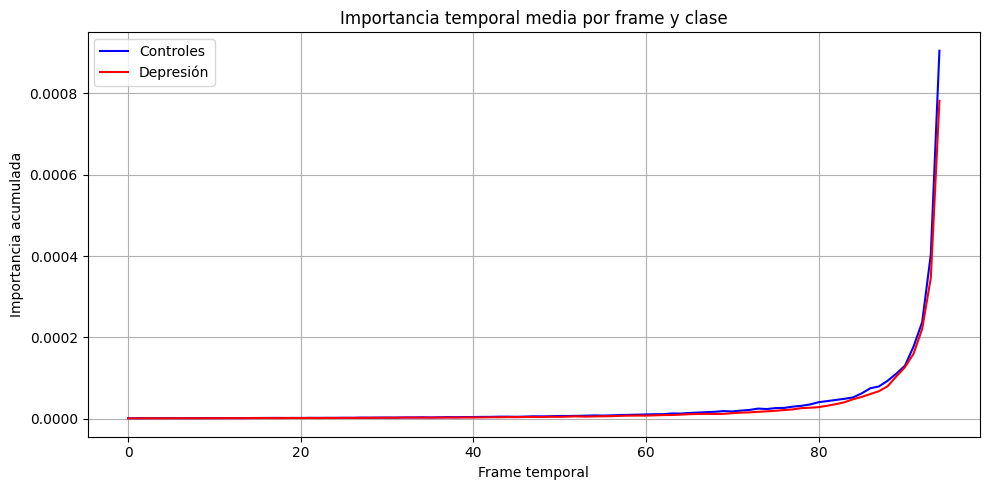

In [9]:
"""
Agrupa las curvas de atribución temporal por clase y visualiza la importancia media por frame.

Usa los valores previamente calculados en `attributions_temporal` para evitar recalcular las
atribuciones. Genera una curva comparativa entre controles (clase 0) y sujetos con depresión (clase 1).
"""
group_0 = attributions_temporal[y == 0]
group_1 = attributions_temporal[y == 1]

mean_0 = np.mean(group_0, axis=0)
mean_1 = np.mean(group_1, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mean_0, label='Controles', color='blue')
plt.plot(mean_1, label='Depresión', color='red')
plt.title("Importancia temporal media por frame y clase")
plt.xlabel("Frame temporal")
plt.ylabel("Importancia acumulada")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "xai_curva_temporal_por_clase.png"), dpi=300, bbox_inches='tight')
plt.show()

In [10]:
df_temporal = pd.DataFrame({
    'frame': np.arange(mean_0.shape[0]),
    'control': mean_0,
    'depresion': mean_1
})
df_temporal.to_csv(os.path.join(output_dir, "xai_curva_temporal_por_clase.csv"), index=False)

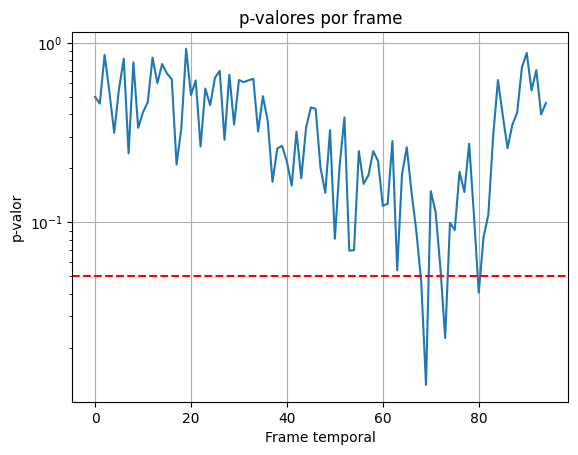

In [11]:
"""
Realiza un test t de Student por frame para comparar la atribución temporal entre clases.

Calcula los p-valores de cada frame entre el grupo control (clase 0) y el grupo con depresión (clase 1),
usando la distribución de importancia acumulada por frame en `attributions_temporal`.

Variables
---------
p_values : np.ndarray
    P-valores obtenidos por frame al comparar ambos grupos.

Visualización
-------------
Gráfico de p-valores por frame con umbral de significación marcado en 0.05 (línea roja).
"""
p_values = []
for f in range(group_0.shape[1]):
    t, p = ttest_ind(group_1[:, f], group_0[:, f], equal_var=False)
    p_values.append(p)

p_values = np.array(p_values)

plt.plot(p_values)
plt.axhline(0.05, color='red', linestyle='--')
plt.title("p-valores por frame")
plt.xlabel("Frame temporal")
plt.ylabel("p-valor")
plt.yscale('log')
plt.grid(True)
plt.savefig(os.path.join(output_dir, "xai_pvalores_por_frame.png"), dpi=300, bbox_inches='tight')
plt.show()

In [12]:
df_pval = pd.DataFrame({
    'frame': np.arange(p_values.shape[0]),
    'p_value': p_values
})
df_pval.to_csv(os.path.join(output_dir, "xai_pvalores_por_frame.csv"), index=False)

In [13]:
significant_frames = np.where(p_values < 0.05)[0]
print("Frames significativos (p < 0.05):", significant_frames)

Frames significativos (p < 0.05): [68 69 73 80]


## 5.4 - Análisis espacial en frames significativos.

En esta sección se analizan las atribuciones espaciales de los frames que han mostrado diferencias estadísticamente significativas entre clases en el análisis temporal.

Para cada muestra se calcula un mapa medio de atribución espacial sobre los frames seleccionados. A continuación, se calcula el promedio global por clase (control y depresión), así como la diferencia entre ambos mapas. Estos resultados permiten observar qué regiones cerebrales son más relevantes
para el modelo y cómo varía esta relevancia entre los grupos.

Finalmente, se visualizan los mapas de atribución medios por clase y la diferencia entre ellos.

In [14]:
"""
Genera los mapas de atribución espacial medios por grupo usando solo los frames significativos.

A partir de las atribuciones espaciales precalculadas (`attributions_spatial`), se extraen
los frames con diferencias significativas (definidos en `significant_frames`), y se calcula
un mapa promedio por sujeto y por grupo (control y depresión).

Variables
---------
maps_control : list of np.ndarray
    Mapas promedio por sujeto del grupo control en los frames significativos.

maps_depresion : list of np.ndarray
    Mapas promedio por sujeto con depresión en los frames significativos.
"""

maps_control = []
maps_depresion = []

for i in tqdm(range(len(attributions_spatial))):
    attr_abs = np.abs(attributions_spatial[i])
    attr_gray = np.mean(attr_abs, axis=-1)

    selected_maps = attr_gray[significant_frames]
    mean_map = np.mean(selected_maps, axis=0)

    if y[i] == 0:
        maps_control.append(mean_map)
    else:
        maps_depresion.append(mean_map)

100%|██████████| 31/31 [00:03<00:00,  9.13it/s]


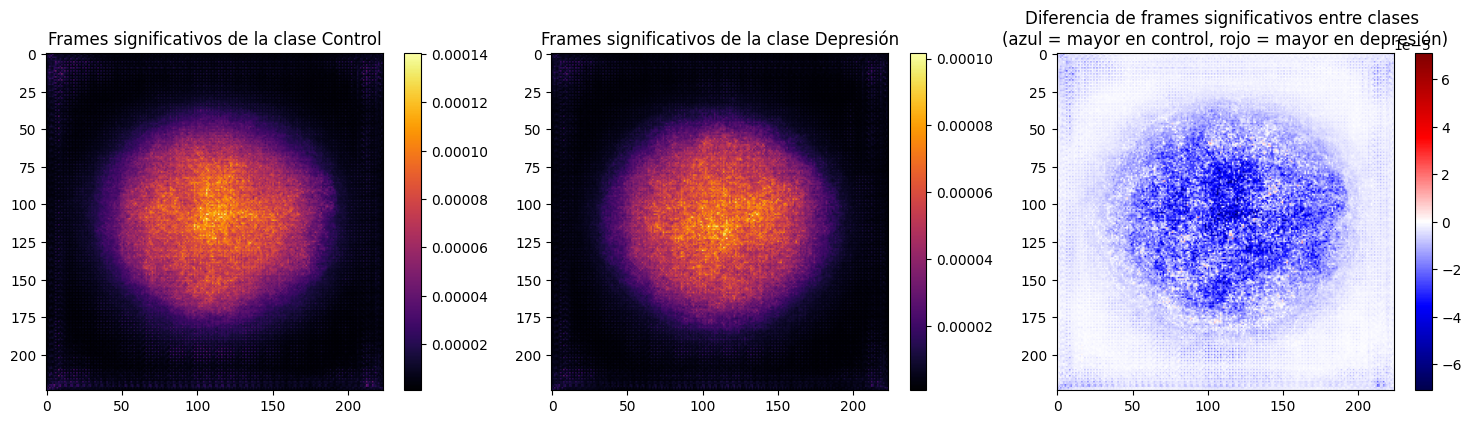

In [21]:
mean_control = np.mean(maps_control, axis=0)
mean_depresion = np.mean(maps_depresion, axis=0)
diff_map = mean_depresion - mean_control

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(mean_control, cmap='inferno')
plt.title('Frames significativos de la clase Control')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(mean_depresion, cmap='inferno')
plt.title('Frames significativos de la clase Depresión')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(diff_map, cmap='seismic', vmin=-np.max(np.abs(diff_map)), vmax=np.max(np.abs(diff_map)))
plt.title('Diferencia de frames significativos entre clases \n(azul = mayor en control, rojo = mayor en depresión)')
plt.colorbar()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "xai_mapas_espaciales_por_grupo.png"), dpi=300, bbox_inches='tight')
plt.show()